In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import pickle
import requests
import os


In [2]:
goodware_train_url = 'https://raw.githubusercontent.com/SamuReyes/MAADM-SEGUR/main/dataset/2000_goodware_2018_2020_features.csv'
malware_train_url = 'https://raw.githubusercontent.com/SamuReyes/MAADM-SEGUR/main/dataset/2000_malware_2018_2020_features.csv'
goodware_test_url = 'https://raw.githubusercontent.com/SamuReyes/MAADM-SEGUR/main/dataset/goodware_features.csv'
malware_test_url = 'https://raw.githubusercontent.com/SamuReyes/MAADM-SEGUR/main/dataset/malware_features.csv'

folder = 'dataset'
os.makedirs(folder, exist_ok=True)
goodware_train_filename = os.path.join(folder, '2000_goodware_2018_2020_features.csv')
malware_train_filename = os.path.join(folder, '2000_malware_2018_2020_features.csv')
goodware_test_filename = os.path.join(folder, 'goodware_features.csv')
malware_test_filename = os.path.join(folder, 'malware_features.csv')

# Descarga los archivos
for url, local_filename in zip([goodware_train_url, malware_train_url, goodware_test_url, malware_test_url],
                                [goodware_train_filename, malware_train_filename, goodware_test_filename, malware_test_filename]):
    response = requests.get(url)
    response.raise_for_status()
    with open(local_filename, 'wb') as f:
        f.write(response.content)

## Data Preparation

In [3]:
goodware = pd.read_csv('./dataset/2000_goodware_2018_2020_features.csv')
malware = pd.read_csv('./dataset/2000_malware_2018_2020_features.csv')
goodware_val = pd.read_csv('./dataset/goodware_features.csv')
malware_val = pd.read_csv('./dataset/malware_features.csv')

In [4]:
def prepare_data(goodware, malware):
    # Asignar etiquetas
    goodware['label'] = 0
    malware['label'] = 1

    # Concatenar y mezclar los datos
    data = pd.concat([goodware, malware], ignore_index=True)
    data = data.sample(frac=1).reset_index(drop=True)

    # Calcular diferencia de versiones y limpiar datos
    data['diff_andrversion'] = data['target_andrversion'] - data['min_andrversion']
    data = data.drop(['hash', 'PackageName', 'max_andrversion', 'target_andrversion', 'min_andrversion'], axis=1)
    
    return data

# Preparar los conjuntos de datos de entrenamiento y validación
data = prepare_data(goodware, malware)
data_val = prepare_data(goodware_val, malware_val)

# Separar las características y etiquetas
X, y = data.drop('label', axis=1), data['label']
X_val, y_val = data_val.drop('label', axis=1), data_val['label']

# Dividir los datos de entrenamiento para crear un subconjunto de validación
X_train, X_val2, y_train, y_val2 = train_test_split(X, y, test_size=0.1)

# Combinar los conjuntos de validación
X_val = pd.concat([X_val, X_val2], ignore_index=True)
y_val = pd.concat([y_val, y_val2], ignore_index=True)


## Classification Model

Single model

In [5]:
# Model
model = CatBoostClassifier(iterations=20, learning_rate=1, depth=2, loss_function='Logloss', verbose=False)

model.fit(X_train, y_train)

accuracy_train = model.score(X_train, y_train)
accuracy_val = model.score(X_val, y_val)

accuracy_train, accuracy_val

(0.98, 0.928643216080402)

Ensemble

In [6]:
estimators = [
    ('catboost', CatBoostClassifier(iterations=20, learning_rate=1, depth=4, loss_function='Logloss', verbose=False)),
    ('random_forest', RandomForestClassifier(n_estimators=20)),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=20)),
    ('lightgbm', LGBMClassifier(n_estimators=20,verbose=-1,verbosity=-1 ))
]

final_estimator = LogisticRegression()

# Configuración del Stacking Classifier
stack_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=6)

# Entrenamiento del modelo
stack_model.fit(X_train, y_train)

StackingClassifier(cv=6,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7ac21c15fd60>),
                               ('random_forest',
                                RandomForestClassifier(n_estimators=20)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(n_estimators=20)),
                               ('lightgbm',
                                LGBMClassifier(n_estimators=20, verbose=-1,
                                               verbosity=-1))],
                   final_estimator=LogisticRegression())

Validation

Train accuracy: 99.50%
Validation accuracy: 93.67%
Train recall: 0.99
Validation recall: 0.96
Train precision: 1.00
Validation precision: 0.92
Train F1 Score: 0.99
Validation F1 Score: 0.94
Train ROC AUC Score: 1.00
Validation ROC AUC Score: 0.97


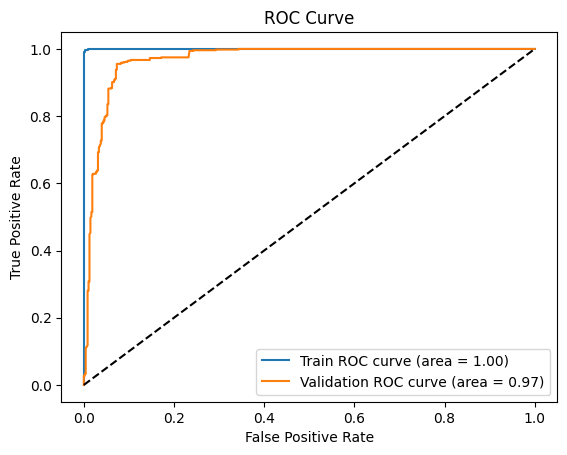

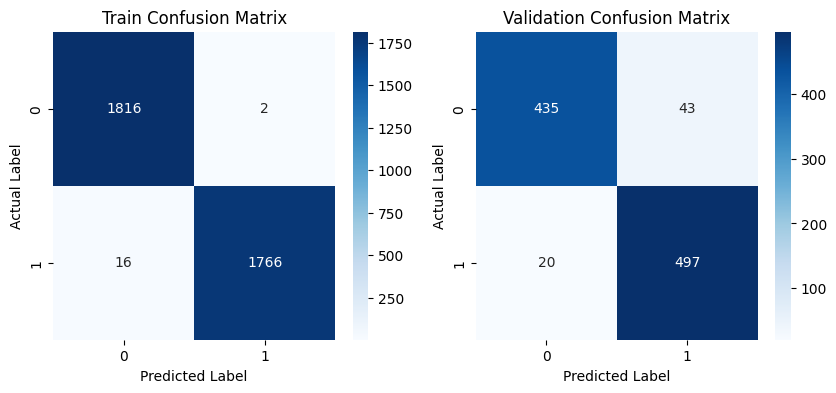

In [7]:


# Realizar predicciones
y_pred_train = stack_model.predict(X_train)
y_pred_val = stack_model.predict(X_val)

# Calcular las métricas de evaluación
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
precision_val = precision_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
roc_auc_train = roc_auc_score(y_train, stack_model.predict_proba(X_train)[:,1])
roc_auc_val = roc_auc_score(y_val, stack_model.predict_proba(X_val)[:,1])

# Imprimir resultados
print(f"Train accuracy: {accuracy_train*100:.2f}%")
print(f"Validation accuracy: {accuracy_val*100:.2f}%")
print(f"Train recall: {recall_train:.2f}")
print(f"Validation recall: {recall_val:.2f}")
print(f"Train precision: {precision_train:.2f}")
print(f"Validation precision: {precision_val:.2f}")
print(f"Train F1 Score: {f1_train:.2f}")
print(f"Validation F1 Score: {f1_val:.2f}")
print(f"Train ROC AUC Score: {roc_auc_train:.2f}")
print(f"Validation ROC AUC Score: {roc_auc_val:.2f}")

# Dibujar ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, stack_model.predict_proba(X_train)[:,1])
fpr_val, tpr_val, _ = roc_curve(y_val, stack_model.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Dibujar Matriz de Confusión
cm_train = confusion_matrix(y_train, y_pred_train)
cm_val = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True,  cmap="Blues", fmt="d")
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, cmap="Blues", fmt="d")
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


Importancia de las features

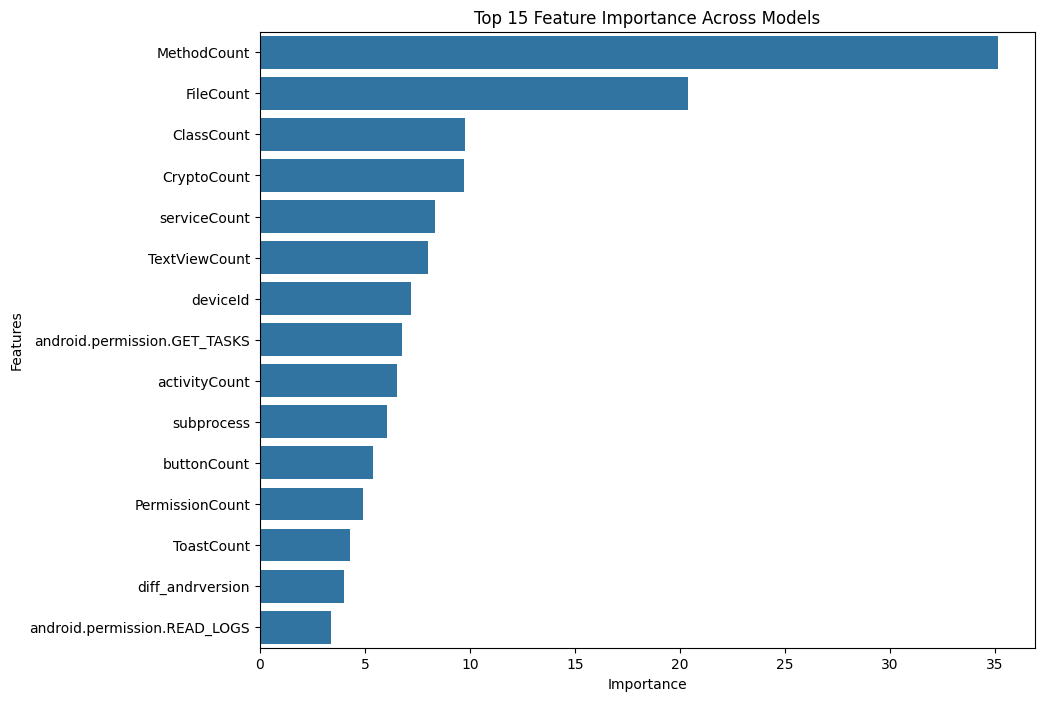

In [8]:

trained_model1 = stack_model.named_estimators_['catboost']
trained_model2 = stack_model.named_estimators_['random_forest']
trained_model3 = stack_model.named_estimators_['lightgbm']
trained_model4 = stack_model.named_estimators_['gradient_boosting']

feature_importances1 = trained_model1.feature_importances_
feature_importances2 = trained_model2.feature_importances_
feature_importances3 = trained_model3.feature_importances_
feature_importances4 = trained_model4.feature_importances_

average_importances = (feature_importances1 + feature_importances2 + feature_importances3 + feature_importances4) / 4

feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Features': feature_names, 'Importance': average_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

top_15_features = feature_importances_df.head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_15_features, x='Importance', y='Features')
plt.title('Top 15 Feature Importance Across Models')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [9]:
# Guardar el modelo
with open('ensemble_model.pkl', 'wb') as file:
    pickle.dump(stack_model, file)

### Testing the model

In [10]:
GOODWARE_TEST = '' # PON TU ARCHIVO DE TESTING AQUI (GOODWARE)
MALWARE_TEST = '' # PON TU ARCHIVO DE TESTING AQUI (MALWARE)

In [ ]:
model_url = 'https://github.com/SamuReyes/MAADM-SEGUR/blob/main/ensemble_model.pkl'
model_filename = 'ensemble_model.pkl'

response = requests.get(model_url)
response.raise_for_status()
with open(model_filename, 'wb') as f:
    f.write(response.content)

In [11]:
# Cargar el modelo
with open('ensemble_model.pkl', 'rb') as file:
    loaded_ensemble = pickle.load(file)

In [12]:
goodware_test = pd.read_csv(GOODWARE_TEST)
malware_test = pd.read_csv(MALWARE_TEST)

In [13]:
def prepare_data(goodware, malware):
    # Asignar etiquetas
    goodware['label'] = 0
    malware['label'] = 1

    # Concatenar y mezclar los datos
    data = pd.concat([goodware, malware], ignore_index=True)
    data = data.sample(frac=1).reset_index(drop=True)

    # Calcular diferencia de versiones y limpiar datos
    data['diff_andrversion'] = data['target_andrversion'] - data['min_andrversion']
    data = data.drop(['hash', 'PackageName', 'max_andrversion', 'target_andrversion', 'min_andrversion'], axis=1)
    
    return data

# Preparar el conjunto de datos
data_test = prepare_data(goodware_test, malware_test)

# Separar las características y etiquetas
X_test, y_test = data_test.drop('label', axis=1), data_test['label']

Test accuracy: 90.25%
Test recall: 0.94
Test precision: 0.88
Test F1 Score: 0.91
Test ROC AUC Score: 0.94


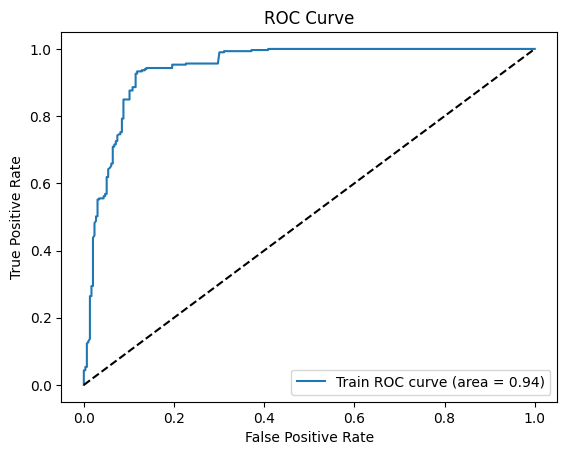

Text(95.72222222222221, 0.5, 'Actual Label')

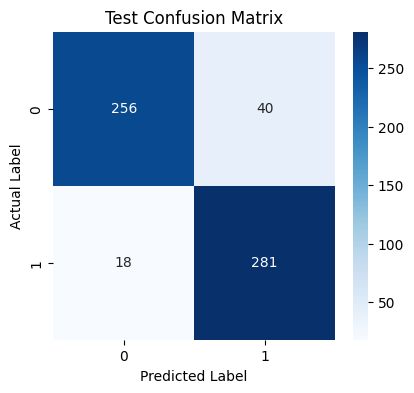

In [14]:
# Realizar predicciones
y_pred_test = stack_model.predict(X_test)

# Calcular las métricas de evaluación
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, stack_model.predict_proba(X_test)[:,1])

# Imprimir resultados
print(f"Test accuracy: {accuracy_test*100:.2f}%")
print(f"Test recall: {recall_test:.2f}")
print(f"Test precision: {precision_test:.2f}")
print(f"Test F1 Score: {f1_test:.2f}")
print(f"Test ROC AUC Score: {roc_auc_test:.2f}")

# Dibujar ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, stack_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'Train ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Dibujar Matriz de Confusión
cm_train = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True,  cmap="Blues", fmt="d")
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
